## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

# 1. Adapting Infection Spread Model for Visualization

### Modeling infection spread using SIR model

In [2]:
def SIR_model(S0, I0, R0, beta, gamma, days):
    dtype = [('day', int), ('susceptible', float), ('infected', float), ('recovered', float)]
    #Initialize arrays
    data = np.zeros(days, dtype=dtype)
    data['day'] = np.arange(days)
    data['susceptible'][0] = S0
    data['infected'][0] = I0
    data['recovered'][0] = R0
    
    #Total population
    N = S0 + I0 + R0 

    #Calculate values
    for t in range(1, days):
        data['susceptible'][t] = data['susceptible'][t-1] - beta * data['susceptible'][t-1] * data['infected'][t-1] / N
        data['infected'][t] = data['infected'][t-1] + beta * data['susceptible'][t-1] * data['infected'][t-1] / N - gamma * data['infected'][t-1]
        data['recovered'][t] = data['recovered'][t-1] + gamma * data['infected'][t-1]

    return data

# --------------------------
# Main Program
# --------------------------

# Initial values
S0 = 990 #Number of susceptible individuals
I0 = 10 #Number of infected individuals
R0 = 0 #Number of recovered individuals
beta = 0.3 #infection rate
gamma = 0.1 #recovery rate
days = 160 #Number of days to simulate

SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)

# Find peak number of infections
peak_infections = np.max(SIR_data['infected'])
peak_day = np.argmax(SIR_data['infected'])
#print(f"\nPeak Day of infections: {peak_day}")

#print("\nSusceptible:\n", SIR_data['susceptible'])
#print("\nInfected:\n", SIR_data['infected'])
#print("\nRecovered:\n", SIR_data['recovered'])



#### Monte Carlo Simulation

In [3]:
# Monte Carlo simulation to estimate the impact of random initial infected
def monte_carlo_simulation(S0, I0_range, R0, beta, gamma, days, num_simulations):

    final_infected = np.zeros(num_simulations)

    for i in range(num_simulations):
        # Randomize the initial number of infected individuals within the specified range
        I0 = np.random.randint(I0_range[0], I0_range[1])
        
        # Run the SIR model
        SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)
        
        # Store the final number of infected individuals
        final_infected[i] = SIR_data['infected'][-1]
    
    return final_infected

S0 = 990
I0_range = (5, 15)
R0 = 0
beta = 0.3
gamma = 0.1
days = 55
num_simulations = 100

# Run Monte Carlo Simulation
final_infected_results = monte_carlo_simulation(S0, I0_range, R0, beta, gamma, days, num_simulations)
#print("Final infected individuals form each simulation\n: ", final_infected_results)

# Analyze the results
mean_final_infected = np.mean(final_infected_results)
std_final_infected = np.std(final_infected_results)

#print(f"\nMean final number of infected individuals: {mean_final_infected}")
#print(f"\nStandard deviation of final number of infected individuals: {std_final_infected}")

### Line Plots of SIR Model Dynamics

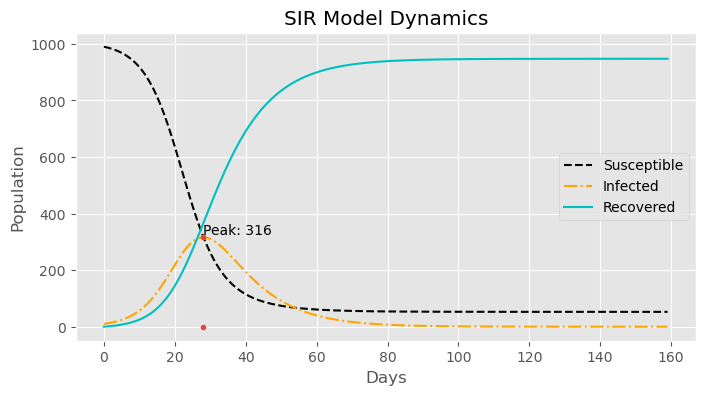

In [4]:
plt.figure(figsize=(8,4))
plt.plot(SIR_data['day'], SIR_data['susceptible'], '--k', label='Susceptible')
plt.plot(SIR_data['day'], SIR_data['infected'], '-.', label='Infected', color='orange')
plt.plot(SIR_data['day'], SIR_data['recovered'], label='Recovered', color='c')
#plt.axvline(peak_day, color='black', linestyle='--')
plt.plot([peak_day, peak_day], [0, peak_infections], '.')
plt.text(peak_day, peak_infections, f'Peak: {peak_infections:.0f}', 
         verticalalignment='bottom', horizontalalignment='left', color='black')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SIR Model Dynamics')
plt.legend();


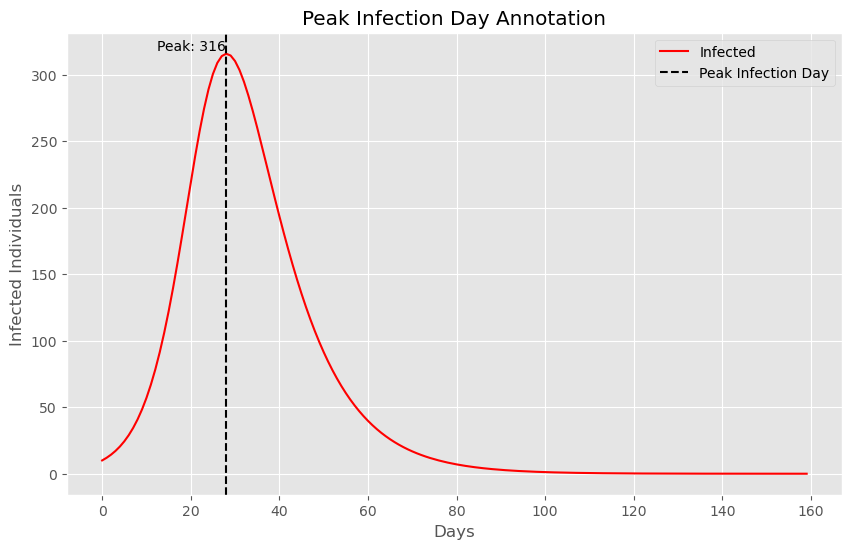

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(SIR_data['day'], SIR_data['infected'], label='Infected', color='red')
plt.axvline(peak_day, color='black', linestyle='--', label='Peak Infection Day')
plt.text(peak_day, peak_infections, f'Peak: {peak_infections:.0f}', 
         verticalalignment='bottom', horizontalalignment='right', color='black')
plt.xlabel('Days')
plt.ylabel('Infected Individuals')
plt.title('Peak Infection Day Annotation')
plt.legend()

### Scatter Plot of Final Infected Individuals from Monte Carlo Simulation

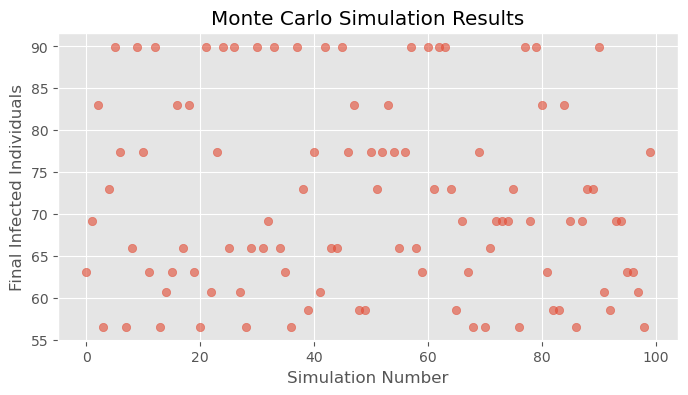

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(range(num_simulations), final_infected_results, alpha=0.6)
plt.xlabel('Simulation Number')
plt.ylabel("Final Infected Individuals")
plt.title('Monte Carlo Simulation Results');

### Histogram of Final Infected Individuals from Monte Carlo Simulation

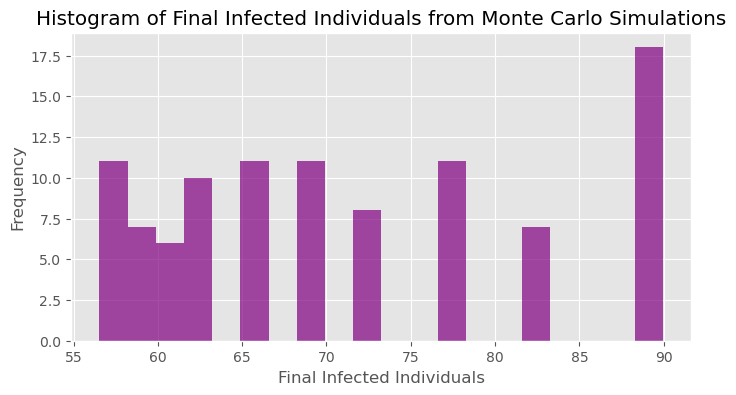

In [7]:
plt.figure(figsize=(8,4))
plt.hist(final_infected_results, bins=20, color='purple', alpha=0.7)
plt.xlabel('Final Infected Individuals')
plt.ylabel('Frequency')
plt.title('Histogram of Final Infected Individuals from Monte Carlo Simulations');

### Density and Contour Plots for SIR Model Parameters

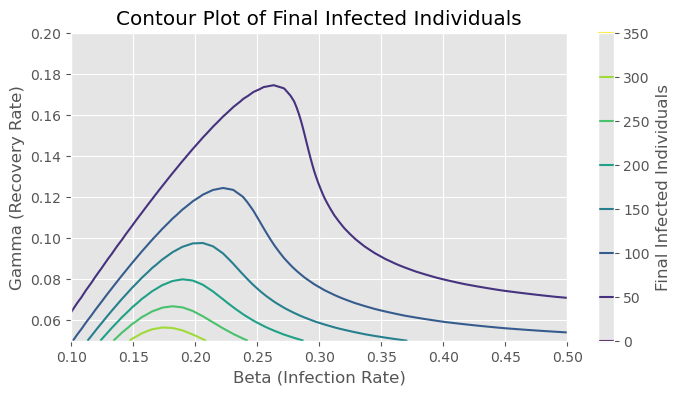

In [64]:
beta_values = np.linspace(0.1, 0.5, 50)
gamma_values = np.linspace(0.05, 0.2, 50)
final_infected = np.zeros((len(beta_values), len(gamma_values)))

for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)
        final_infected[i,j] = SIR_data['infected'][-1]
        
plt.figure(figsize=(8,4))
plt.contour(beta_values, gamma_values, final_infected.T, cmap='viridis')
plt.colorbar(label='Final Infected Individuals')
plt.xlabel('Beta (Infection Rate)')
plt.ylabel('Gamma (Recovery Rate)')
plt.title('Contour Plot of Final Infected Individuals');

### 3D Plot of SIR Model

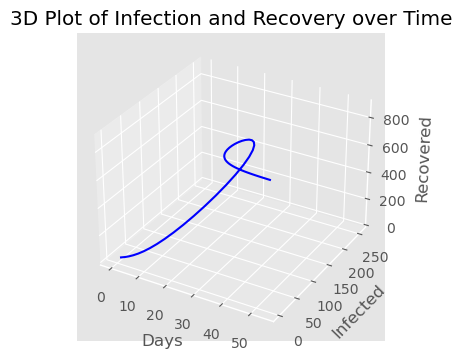

In [9]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(SIR_data['day'], SIR_data['infected'], SIR_data['recovered'], color='blue')
ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax.set_zlabel('Recovered')
ax.set_title('3D Plot of Infection and Recovery over Time');

### Interactive Plot of SIR Model

##### Interactive Recovery and Infection variables

In [10]:
from ipywidgets import interact, FloatSlider
# interactive plotting for SIR model
def plot_SIR(beta, gamma):
    S0 = 1000
    I0 = 1
    R0 = 0
    days = 200
    
    SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)
    
    peak_infections = np.max(SIR_data['infected'])
    peak_day = np.argmax(SIR_data['infected'])
    
    plt.figure(figsize=(8,4))
    plt.plot(SIR_data['day'], SIR_data['susceptible'], '--k', label='Susceptible')
    plt.plot(SIR_data['day'], SIR_data['infected'], '-.', label='Infected', color='orange')
    plt.plot(SIR_data['day'], SIR_data['recovered'], label='Recovered', color='c')
    #plt.axvline(peak_day, color='black', linestyle='--')
    plt.plot([peak_day, peak_day], [0, peak_infections], '.')
    plt.text(peak_day, peak_infections, f'Peak Infections: {peak_infections:.0f}', 
            verticalalignment='bottom', horizontalalignment='left', color='black')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title('Interactive SIR Model Dynamics')
    plt.legend();
    
beta_slider = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, description='Beta')
gamma_slider = FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Gamma')

interact(plot_SIR, beta=beta_slider, gamma=gamma_slider);

interactive(children=(FloatSlider(value=0.3, description='Beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

##### Interactive Variables

In [49]:
from ipywidgets import interact, FloatSlider, IntSlider, BoundedIntText, jslink
# interactive plotting for SIR model
def plot_SIR(S0, I0, R0, beta, gamma):
    days=100
    SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)
    
    peak_infections = np.max(SIR_data['infected'])
    peak_day = np.argmax(SIR_data['infected'])
    
    plt.figure(figsize=(8,4))
    plt.plot(SIR_data['day'], SIR_data['susceptible'], '--k', label='Susceptible')
    plt.plot(SIR_data['day'], SIR_data['infected'], '-.', label='Infected', color='orange')
    plt.plot(SIR_data['day'], SIR_data['recovered'], label='Recovered', color='c')
    #plt.axvline(peak_day, color='black', linestyle='--')
    plt.plot([peak_day, peak_day], [0, peak_infections], '.')
    plt.text(peak_day, peak_infections, f'Peak Infections: {peak_infections:.0f}', 
            verticalalignment='bottom', horizontalalignment='left', color='black')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title('Interactive SIR Model Dynamics')
    plt.legend(fancybox=True, frameon=True, framealpha=1, facecolor='white', edgecolor='black', title='Legend:', borderpad=1);

susceptible_text = BoundedIntText(value=990, min=0, max=2000, step=1, description='Susceptible:')
susceptible_slider = IntSlider(value=990, min=0, max=2000, step=1, description='Susceptible:')
infected_text = BoundedIntText(value=10, min=0, max=2000, step=1, description='Infected:')
recovered_text = BoundedIntText(value=0, min=0, max=2000, step=1, description='Recovered:')
beta_slider = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, description='Beta:')
gamma_slider = FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Gamma:')
#day_slider = FloatSlider(value=160, min=0, max=500, step=1, description='Days')

interact(plot_SIR, S0=susceptible_text, I0=infected_text, R0=recovered_text, beta=beta_slider, gamma=gamma_slider);

interactive(children=(BoundedIntText(value=990, description='Susceptible:', max=2000), BoundedIntText(value=10…

### Trajectory Plot (Phase Plane Plot)

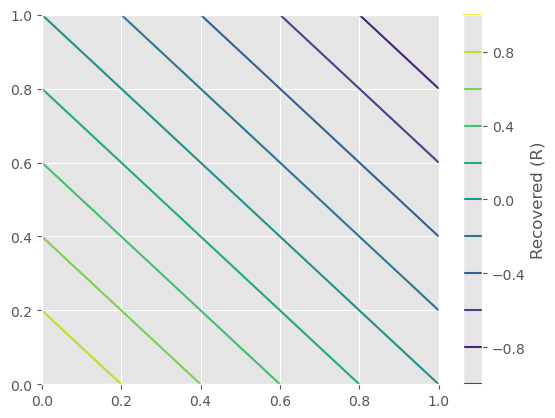

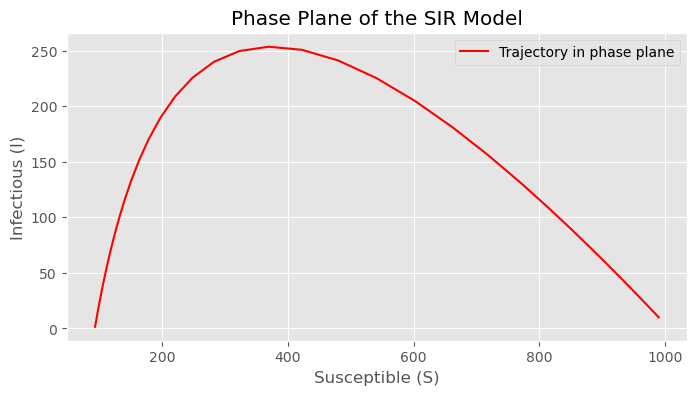

In [12]:
S_vals = np.linspace(0, 1, 100)
I_vals = np.linspace(0, 1, 100)
S_grid, I_grid = np.meshgrid(S_vals, I_vals)
R_grid = 1 - S_grid - I_grid  # Since S + I + R = 1
contour = plt.contour(S_grid, I_grid, R_grid, levels=10, cmap='viridis')
plt.colorbar(contour, label='Recovered (R)')
plt.figure(figsize=(8,4))
plt.plot(SIR_data['susceptible'], SIR_data['infected'], label='Trajectory in phase plane', color='red')
plt.xlabel('Susceptible (S)')
plt.ylabel('Infectious (I)')
plt.title('Phase Plane of the SIR Model')
plt.legend();

# 2. Adapting Movie Data Analysis for Visualization

#### Load Dataset and clean it up

In [13]:
# Load the dataset
movies_df = pd.read_csv("CSV Files//imdb_top_1000.csv")

# Add a 'Rank' column
movies_df['Rank'] = range(1, len(movies_df) + 1)

# Reorder the DataFrame Columns
new_columns = list(movies_df.columns)
new_columns.remove('Rank')
new_columns.insert(0, 'Rank')
movies_df = movies_df[new_columns]

# reducing types of genres
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Crime.*', 'Crime', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Action.*', 'Action', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Biography.*', 'Biography', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Animation.*', 'Animation', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Mystery.*', 'Mystery', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Drama.*', 'Drama', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Adventure.*', 'Adventure', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Romance$', 'Romance', regex=True)
movies_df['Genre'] = movies_df['Genre'].str.replace(r'Comedy.*', 'Comedy', regex=True)

# drop unused columns
movies_df.drop(['Certificate', 'Poster_Link'], axis=1, inplace=True)

# remove rows with null data
movies_df.dropna(inplace=True)

# Convert 'Gross' to numbers
movies_df['Gross'] = movies_df['Gross'].replace(r'[\$,]', '', regex=True).str.strip()
movies_df['Gross'] = pd.to_numeric(movies_df['Gross'])

# Convert 'Runtime' to numbers
movies_df['Runtime'] = movies_df['Runtime'].str.replace(' min', '')
movies_df['Runtime'] = pd.to_numeric(movies_df['Runtime'])

# Convert 'Released_Year' to datetime
valid_year_mask = movies_df['Released_Year'].str.match(r'^\d{4}$')
movies_df = movies_df.loc[valid_year_mask].copy()
movies_df['Released_Year'] = pd.to_datetime(movies_df['Released_Year'] + '-01-01')
movies_df['Released_Year'] = movies_df['Released_Year'].dt.year

# Clean up 'Genre' strings
movies_df['Genre'] = movies_df['Genre'].str.strip().str.lower()

# Sorting the data by ratings
movies_df = movies_df.sort_values(by='IMDB_Rating', ascending=False)

# Resetting the index
movies_df.reset_index(drop=True, inplace=True)

# Updating the 'Rank' column
movies_df['Rank'] = movies_df.index + 1

# Setting the 'Rank' column as the index
movies_df.set_index('Rank', inplace=True)

# Print first few rows of dataset
movies_df.head()

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
Rank,,,,,,,,,,,,,,
1,The Shawshank Redemption,1994,142,drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
2,The Godfather,1972,175,crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
3,The Dark Knight,2008,152,action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
4,The Godfather: Part II,1974,202,crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000
5,12 Angry Men,1957,96,crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000


#### Distribution of IMDB Ratings

c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


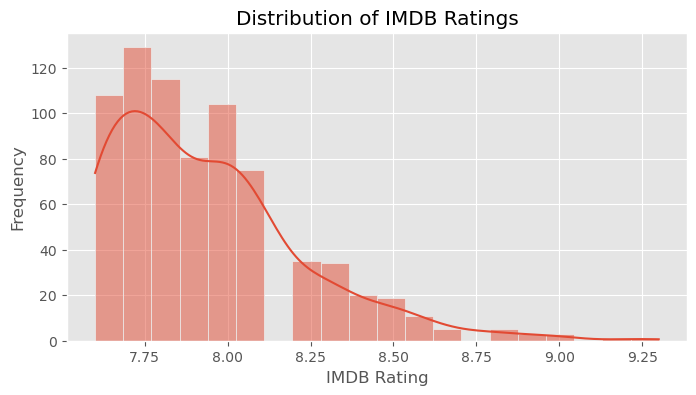

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(movies_df['IMDB_Rating'], kde=True, bins=20)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency');

#### Distribution of Gross Earnings

c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


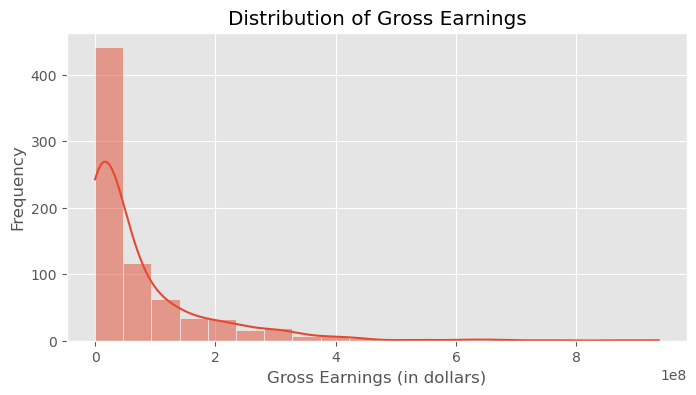

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(movies_df['Gross'], kde=True, bins=20)
plt.title('Distribution of Gross Earnings')
plt.xlabel('Gross Earnings (in dollars)')
plt.ylabel('Frequency');

#### Distribution of Movie Runtimes

c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


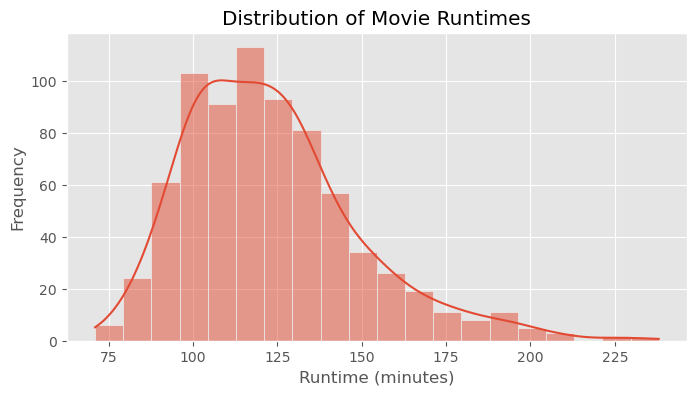

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(movies_df['Runtime'], kde=True, bins=20)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency');

#### Number of Movies Released per Year

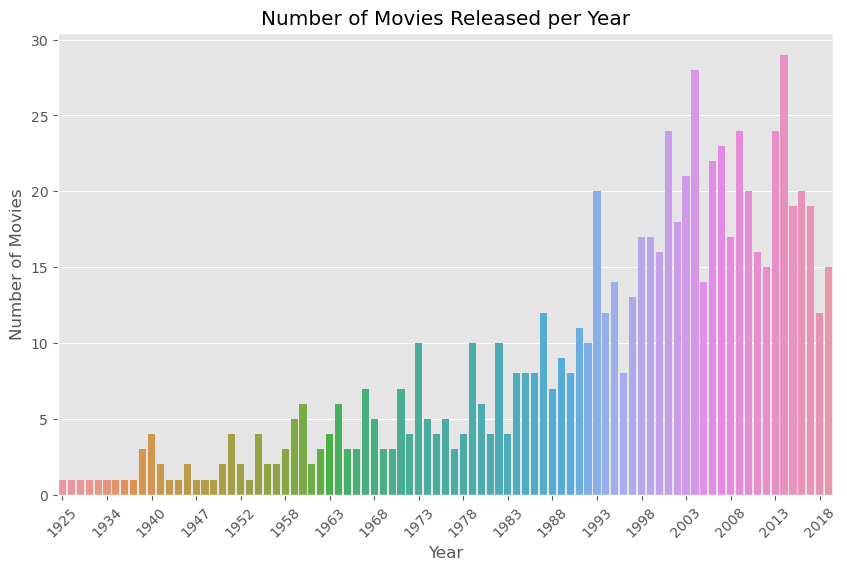

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(data=movies_df, x='Released_Year')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, fontsize=10)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20));

#### Average IMDB Rating by Genre

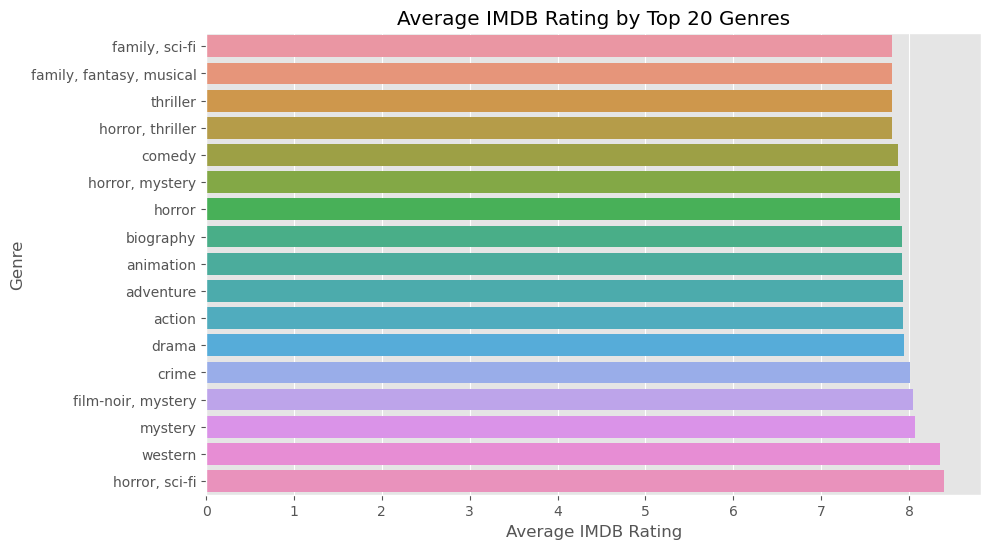

In [18]:
plt.figure(figsize=(10,6))
top_genres = movies_df['Genre'].value_counts().head(20).index
top_genre_ratings = movies_df[movies_df['Genre'].isin(top_genres)].groupby('Genre')['IMDB_Rating'].mean().sort_values()
sns.barplot(x=top_genre_ratings, y=top_genre_ratings.index)
plt.title('Average IMDB Rating by Top 20 Genres')
plt.xlabel('Average IMDB Rating')
plt.ylabel('Genre');

#### Scatter Plot of Gross Earnings vs IMDB Rating

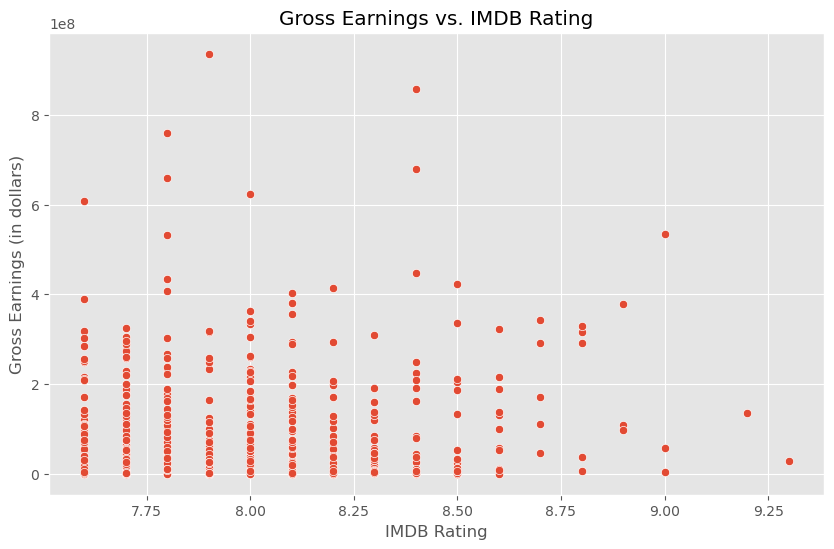

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='IMDB_Rating', y='Gross')
plt.title('Gross Earnings vs. IMDB Rating')
plt.xlabel('IMDB Rating')
plt.ylabel('Gross Earnings (in dollars)')
plt.show()

#### Box Plot of IMDB Ratings by Genre

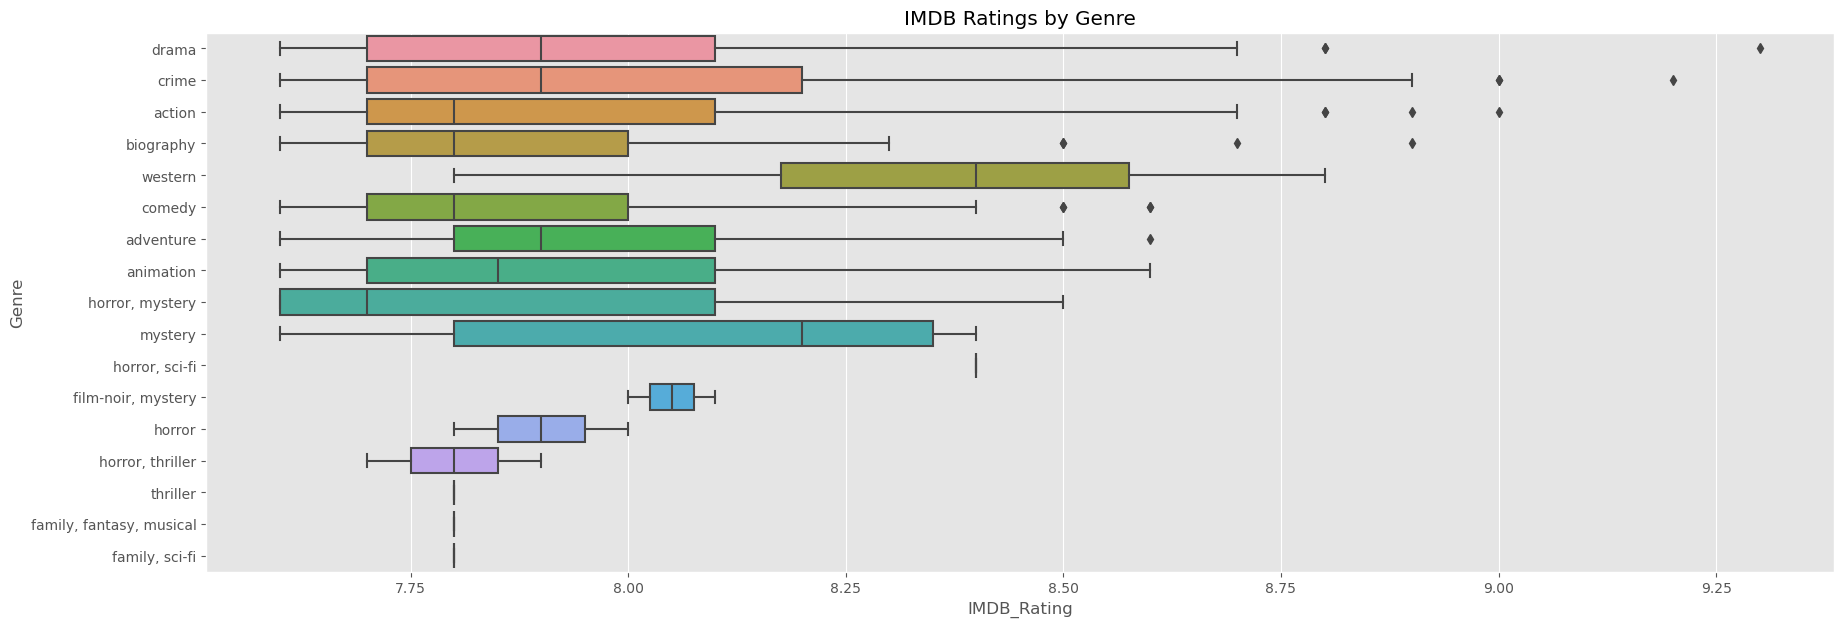

In [20]:
plt.figure(figsize=(21,7))
sns.boxplot(data=movies_df, x='IMDB_Rating', y='Genre')
plt.title('IMDB Ratings by Genre')
plt.ylabel('Genre');

#### Visualizing top directors

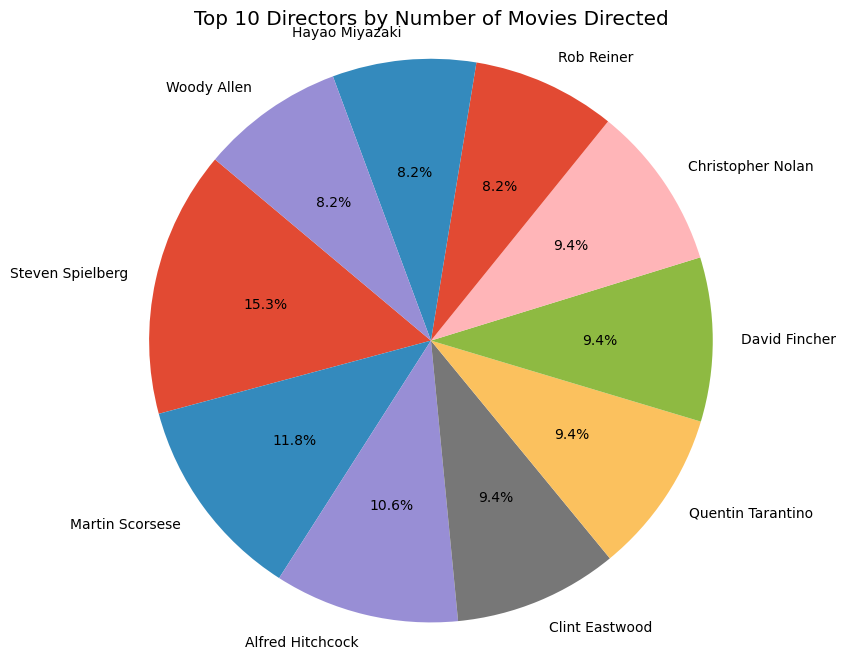

In [21]:
director_counts = movies_df['Director'].value_counts()

top_directors = director_counts.head(10)

plt.figure(figsize=(8,8))
plt.pie(top_directors, labels=top_directors.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Directors by Number of Movies Directed')
plt.axis('equal');

#### Genre Popularity Over Time with Streamgraph

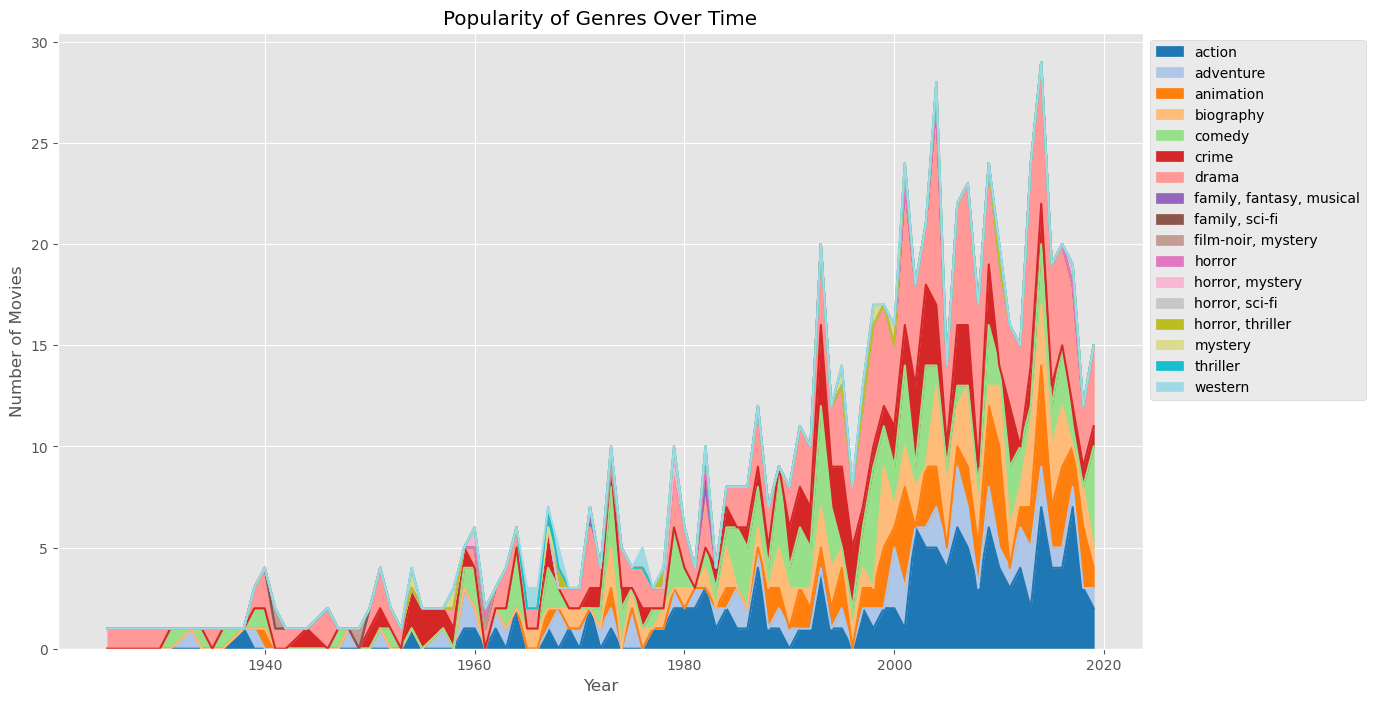

In [22]:
genre_year_count = movies_df.groupby(['Released_Year', 'Genre']).size().unstack().fillna(0)

genre_year_count.plot(kind='area', stacked=True, figsize=(14,8), cmap='tab20')
plt.title('Popularity of Genres Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(loc='upper left', bbox_to_anchor=(1,1));

#### Pairplot of Ratings, Gross, and Runtime

c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\John Wesley\Miniconda3\envs\MY-ENV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


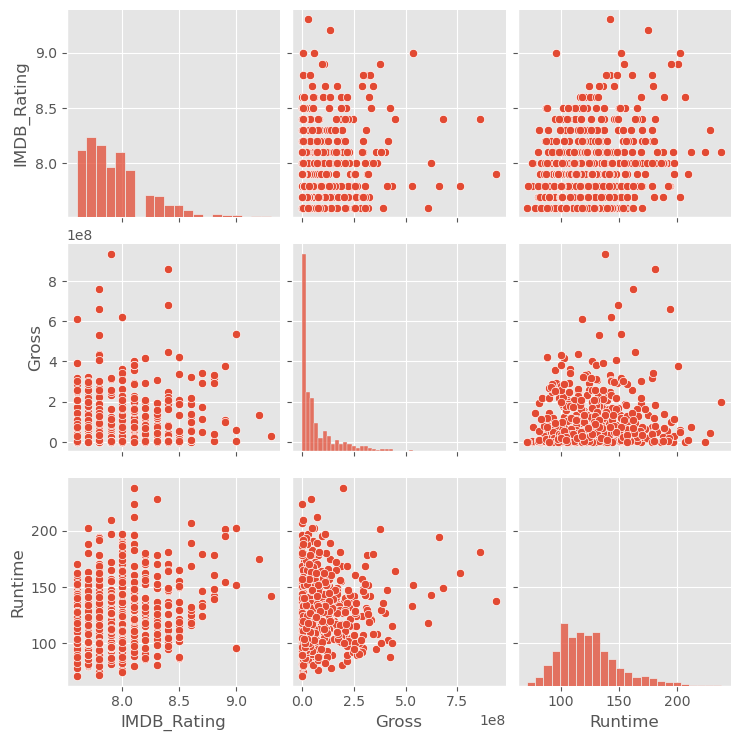

In [23]:
sns.pairplot(movies_df[['IMDB_Rating', 'Gross', 'Runtime']]);

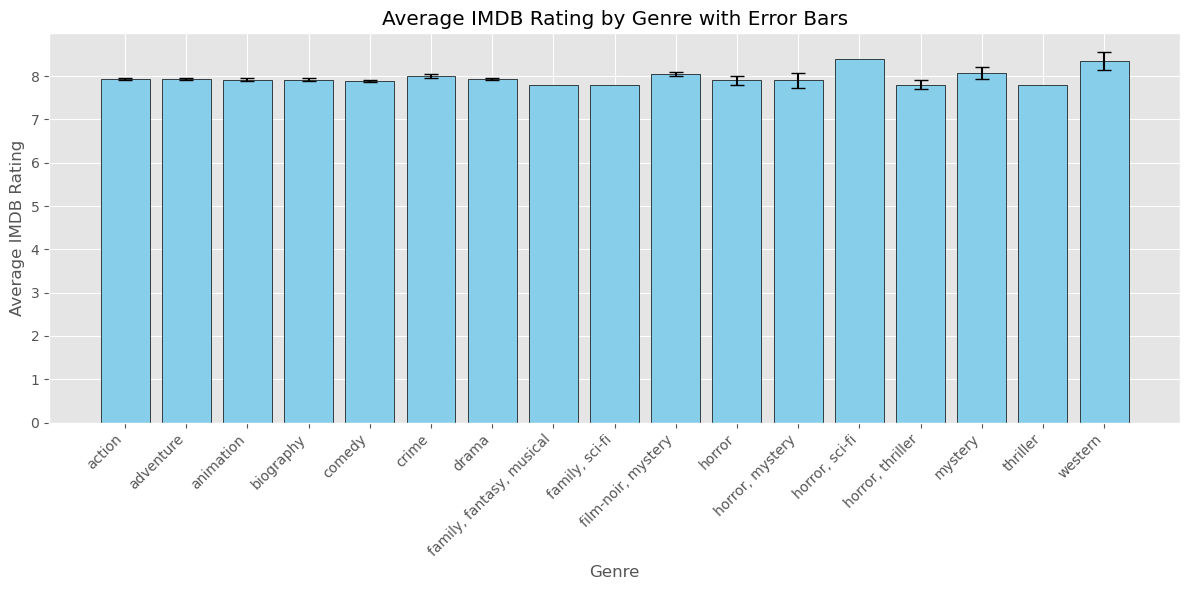

In [24]:
# Plotting the bar plot with error bars
genre_stats = movies_df.groupby('Genre')['IMDB_Rating'].agg(['mean', 'sem']).reset_index()
plt.figure(figsize=(12, 6))
plt.bar(genre_stats['Genre'], genre_stats['mean'], yerr=genre_stats['sem'], capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Average IMDB Rating')
plt.title('Average IMDB Rating by Genre with Error Bars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Covid-19 Data

#### Loading the data

In [25]:
covid_df = pd.read_csv("CSV Files//JHU-03-08-2023.csv")
covid_df = covid_df.dropna(subset=['Lat', 'Long_'])
# Fill missing values in 'Deaths', 'Recovered', and 'Confirmed' columns with zeros
covid_df['Deaths'] = covid_df['Deaths'].fillna(0)
covid_df['Recovered'] = covid_df['Recovered'].fillna(0)
covid_df['Confirmed'] = covid_df['Confirmed'].fillna(0)
covid_df.head()



,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2023-03-09 04:32:54,32.3182,-86.9023,1644533,21032,0.0,NaN,1.0,33540.096896,NaN,NaN,1.278904,84000001.0,USA,NaN,NaN
1,Alaska,US,2023-03-09 04:32:54,61.3707,-152.4044,307655,1486,0.0,NaN,2.0,42055.512648,NaN,NaN,0.483009,84000002.0,USA,NaN,NaN
2,American Samoa,US,2023-03-09 04:32:54,-14.2710,-170.1320,8320,34,0.0,NaN,60.0,14953.002282,NaN,NaN,0.408654,16.0,ASM,NaN,NaN
3,Arizona,US,2023-03-09 04:32:54,33.7298,-111.4312,2443514,33102,0.0,NaN,4.0,33570.669117,NaN,NaN,1.354688,84000004.0,USA,NaN,NaN
4,Arkansas,US,2023-03-09 04:32:54,34.9697,-92.3731,1006622,13015,0.0,NaN,5.0,33356.109277,NaN,NaN,1.292938,84000005.0,USA,NaN,NaN


### Making the map

C:\Users\John Wesley\AppData\Local\Temp\ipykernel_23016\366501176.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  m.scatter(x, y, s=covid_df['Confirmed']/500, c=covid_df['Confirmed'], cmap=plt.cm.get_cmap('Reds', 4), alpha=0.6, edgecolors='w', linewidth=0.5, zorder=2)


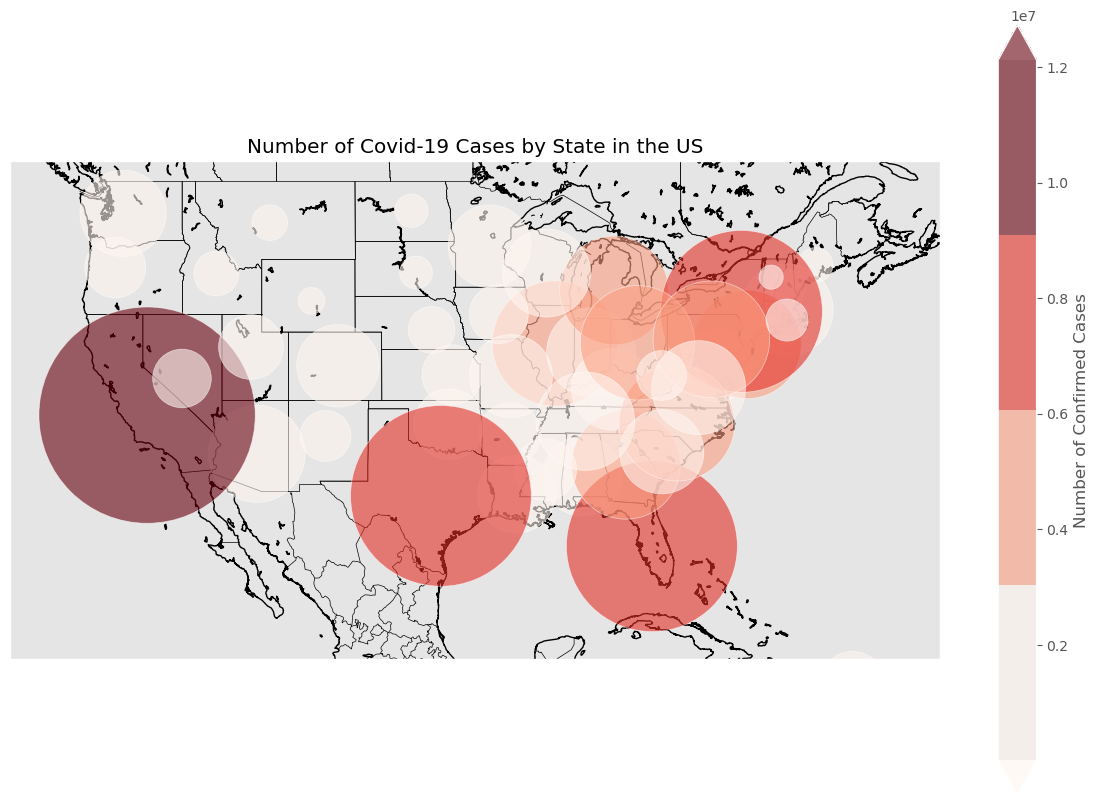

In [53]:
plt.figure(figsize=(15,10))
#m = Basemap(projection='lcc', resolution='l', width=5E6, height=3E6, lat_0=37.5, lon_0=-97)
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='i')
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color='w', lake_color='aqua')
m.drawcoastlines()
m.drawstates()
m.drawcountries();

x, y = m(covid_df['Long_'].values, covid_df['Lat'].values)
m.scatter(x, y, s=covid_df['Confirmed']/500, c=covid_df['Confirmed'], cmap=plt.cm.get_cmap('Reds', 4), alpha=0.6, edgecolors='w', linewidth=0.5, zorder=2)
plt.colorbar(label='Number of Confirmed Cases', extend='both')
plt.title('Number of Covid-19 Cases by State in the US');


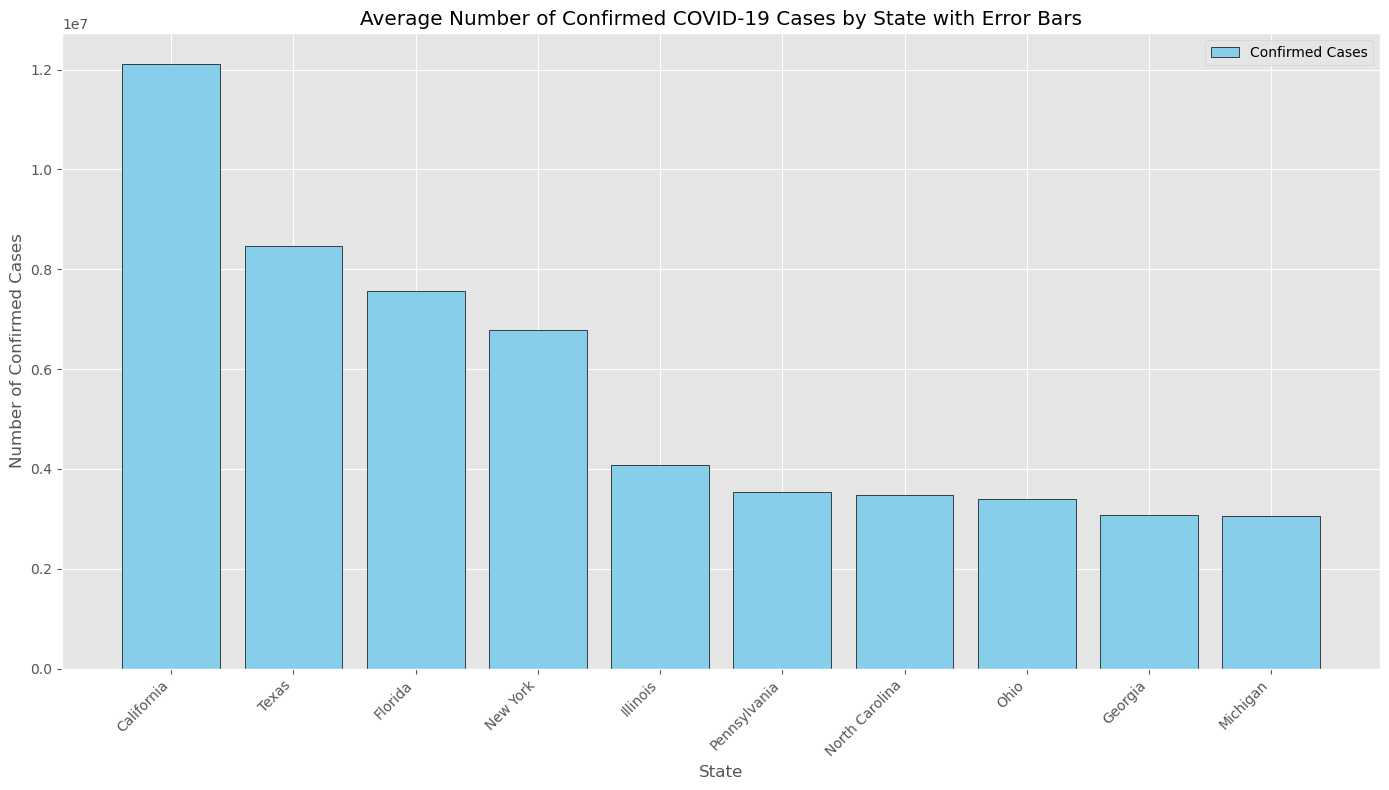

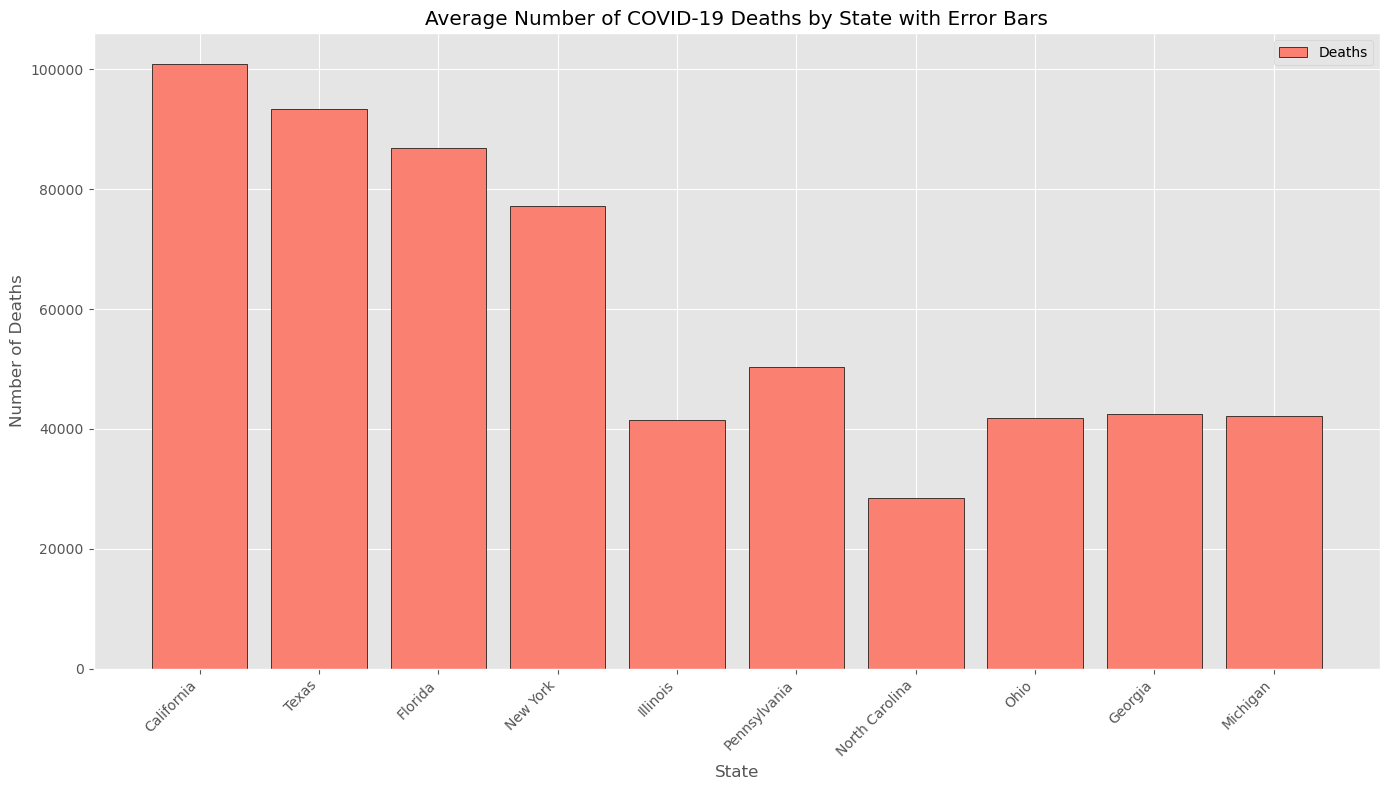

In [36]:
# Group by state and calculate mean and standard deviation for 'Confirmed' and 'Deaths'
state_stats = covid_df.groupby('Province_State').agg({
    'Confirmed': ['mean', 'std'],
    'Deaths': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
state_stats.columns = ['Province_State', 'Confirmed_mean', 'Confirmed_std', 'Deaths_mean', 'Deaths_std']

# Filter to get the top 10 states by mean confirmed cases
top_states = state_stats.nlargest(10, 'Confirmed_mean')

# Plotting the bar plot with error bars
plt.figure(figsize=(14, 8))

# Plot for confirmed cases
plt.bar(top_states['Province_State'], top_states['Confirmed_mean'], yerr=top_states['Confirmed_std'], 
        capsize=5, color='skyblue', edgecolor='black', label='Confirmed Cases')

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Number of Confirmed Cases')
plt.title('Average Number of Confirmed COVID-19 Cases by State with Error Bars')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the bar plot with error bars for deaths
plt.figure(figsize=(14, 8))

# Plot for deaths
plt.bar(top_states['Province_State'], top_states['Deaths_mean'], yerr=top_states['Deaths_std'], 
        capsize=5, color='salmon', edgecolor='black', label='Deaths')

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Number of Deaths')
plt.title('Average Number of COVID-19 Deaths by State with Error Bars')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



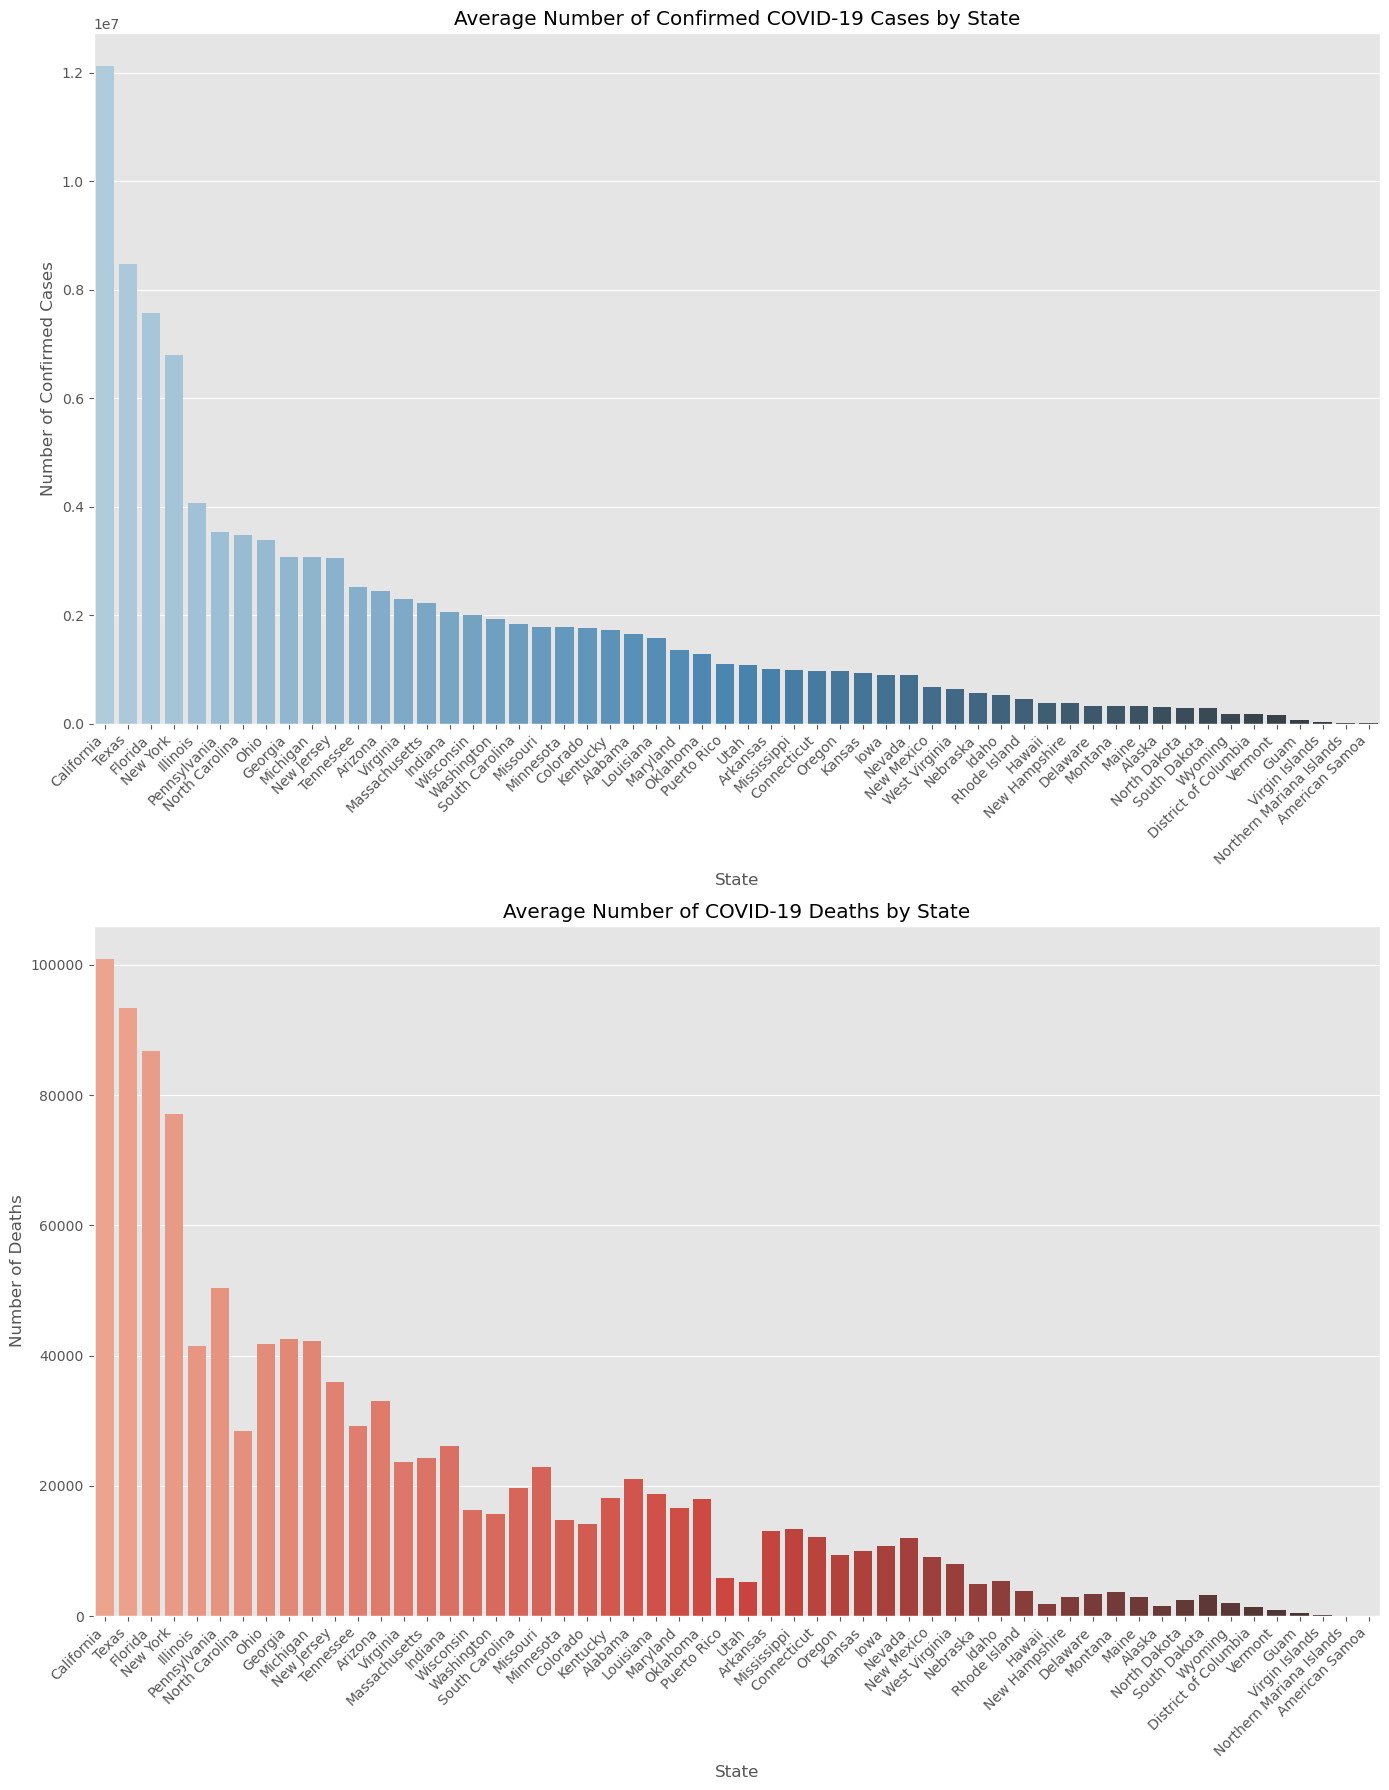

In [63]:
# Aggregating data for visualization
top_states = covid_df.groupby('Province_State').agg({
    'Confirmed': 'mean',
    'Deaths': 'mean',
    'Recovered': 'mean'
}).reset_index()

# Selecting top states by confirmed cases
top_states = top_states.sort_values(by='Confirmed', ascending=False)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 18))

# Plotting the bar plot for confirmed cases
sns.barplot(x='Province_State', y='Confirmed', data=top_states, ax=ax[0], palette='Blues_d')
ax[0].set_xlabel('State')
ax[0].set_ylabel('Number of Confirmed Cases')
ax[0].set_title('Average Number of Confirmed COVID-19 Cases by State')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xticks(range(len(top_states['Province_State'])))  # Set x-ticks manually
ax[0].set_xticklabels(top_states['Province_State'], rotation=45, ha='right')  # Set tick labels with rotation

# Plotting the bar plot for deaths
sns.barplot(x='Province_State', y='Deaths', data=top_states, ax=ax[1], palette='Reds_d')
ax[1].set_xlabel('State')
ax[1].set_ylabel('Number of Deaths')
ax[1].set_title('Average Number of COVID-19 Deaths by State')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xticks(range(len(top_states['Province_State'])))
ax[1].set_xticklabels(top_states['Province_State'], rotation=45, ha='right')

plt.tight_layout();


In [65]:
### Pokemon Data Analysis and Visualization
#### Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Read in dataset
poke_df = pd.read_csv('CSV FIles//pokemon.csv')

display(poke_df)
poke_df.info()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


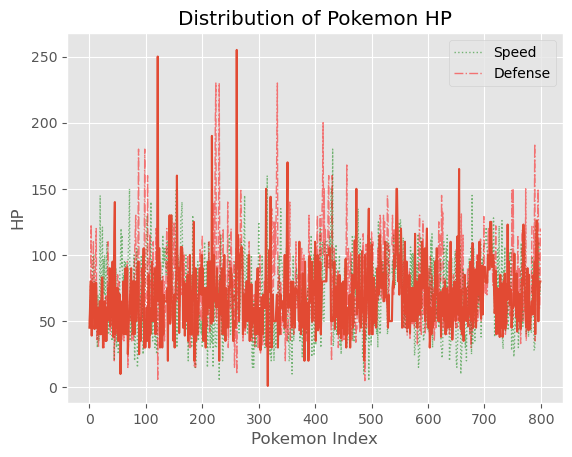

In [29]:

#### Line Plot
poke_df.Speed.plot(kind = 'line', color = 'g', label = 'Speed', linewidth=1,
                   alpha=0.5, grid=True, linestyle=':')
poke_df.Defense.plot(color='r', label='Defense', linewidth=1, alpha=0.5,
                     grid=True, linestyle='-.')
plt.legend(loc='upper right')
plt.xlabel('Pokemon Index')
plt.ylabel('Stat')
plt.title('Line Plot');
plt.plot(poke_df['HP'])
plt.xlabel('Pokemon Index')
plt.ylabel('HP')
plt.title('Distribution of Pokemon HP');

<Figure size 1200x600 with 0 Axes>

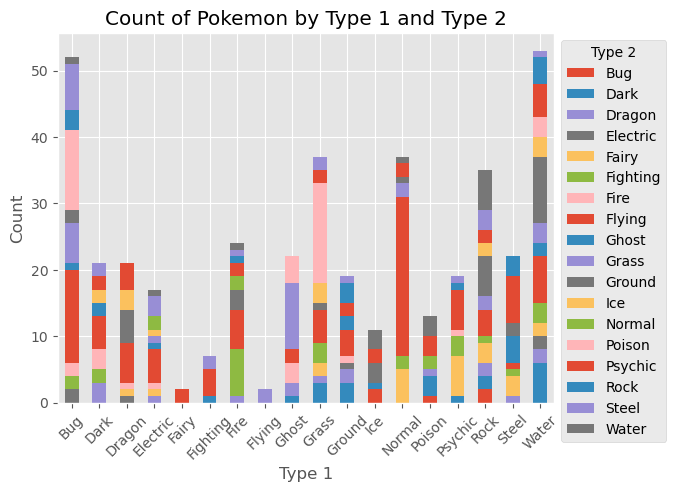

In [30]:

plt.figure(figsize=(12, 6))
poke_df.groupby(['Type 1', 'Type 2']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Type 1')
plt.ylabel('Count')
plt.title('Count of Pokemon by Type 1 and Type 2')
plt.xticks(rotation=45)
plt.legend(title='Type 2', bbox_to_anchor=(1, 1));

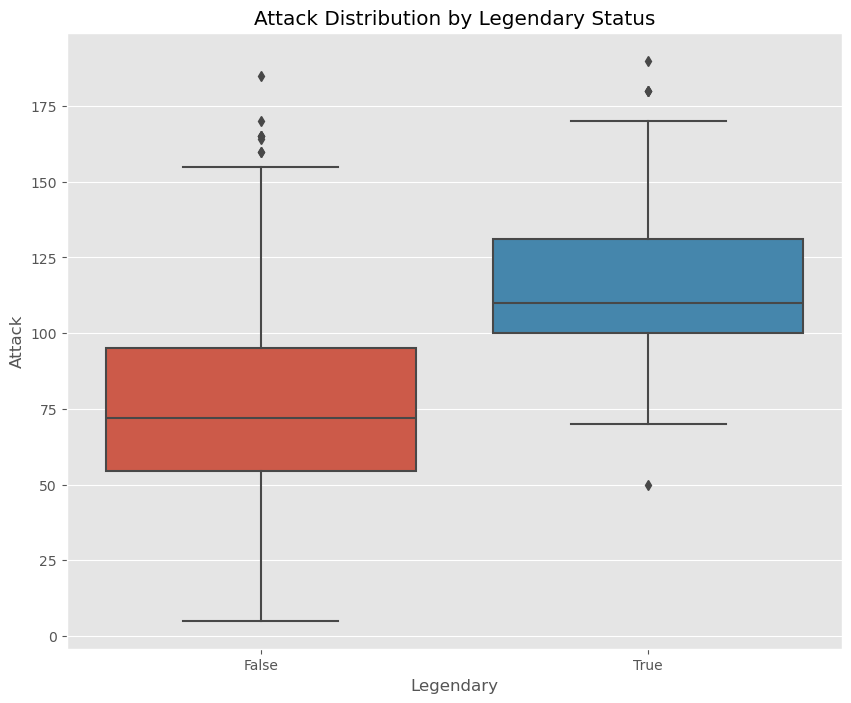

In [31]:

#### Box plot comparing the distributions of Pokemon Attack Stats across different Legendary statuses
plt.figure(figsize=(10,8))
sns.boxplot(x='Legendary', y='Attack', data=poke_df)
plt.xlabel('Legendary')
plt.ylabel('Attack')
plt.title('Attack Distribution by Legendary Status');



### Violin Plot with Pokemon Data

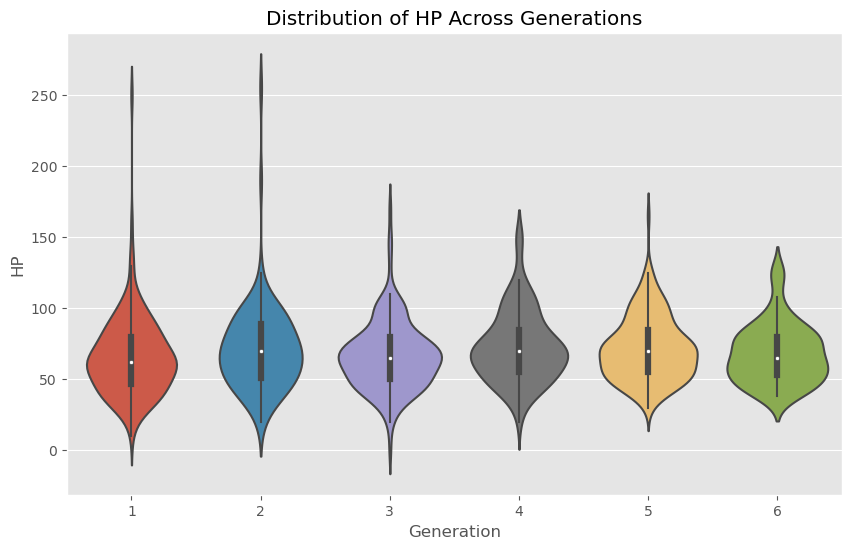

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Generation', y='HP', data=poke_df)
plt.xlabel('Generation')
plt.ylabel('HP')
plt.title('Distribution of HP Across Generations')
plt.show()